<a href="https://colab.research.google.com/github/gulce0/IE-423/blob/main/Task10_Gulce_ipynb_adl%C4%B1_not_defterinin_kopyas%C4%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting National Electricity Load

## Importing Required Libraries for Analysis

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error


In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading the data

In [18]:
# Reading the data
continuous_dataset= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/task10/continuous.csv')

# Load the Excel files
train_dataframes_path = '/content/drive/MyDrive/Colab Notebooks/data/task10/train_dataframes.xlsx'
test_dataframes_path = '/content/drive/MyDrive/Colab Notebooks/data/task10/test_dataframes.xlsx'

# Load the Excel files
train_dataframes = pd.read_excel(train_dataframes_path, sheet_name=None)
test_dataframes = pd.read_excel(test_dataframes_path, sheet_name=None)


In [19]:
continuous_dataset.head()

,datetime,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
0,2015-01-03 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
1,2015-01-03 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2,2015-01-03 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
3,2015-01-03 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
4,2015-01-03 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0


In [10]:

print(train_dataframes.keys())
print(test_dataframes.keys())


dict_keys(['Week 15, Apr 2019', 'Week 21, May 2019', 'Week 24, Jun 2019', 'Week 29, Jul 2019', 'Week 33, Aug 2019', 'Week 37, Sep 2019', 'Week 41, Oct 2019', 'Week 44, Nov 2019', 'Week 51, Dec 2019', 'Week 01, Jan 2020', 'Week 06, Feb 2020', 'Week 10, Mar 2020', 'Week 20, May 2020', 'Week 24, Jun 2020'])
dict_keys(['Week 15, Apr 2019', 'Week 21, May 2019', 'Week 24, Jun 2019', 'Week 29, Jul 2019', 'Week 33, Aug 2019', 'Week 37, Sep 2019', 'Week 41, Oct 2019', 'Week 44, Nov 2019', 'Week 51, Dec 2019', 'Week 01, Jan 2020', 'Week 06, Feb 2020', 'Week 10, Mar 2020', 'Week 20, May 2020', 'Week 24, Jun 2020'])


In [11]:
# For demonstration, we'll use the first train and test dataframe
train_df = train_dataframes[list(train_dataframes.keys())[0]]
test_df = test_dataframes[list(test_dataframes.keys())[0]]

# Display the column names to find the correct target column
print(train_df.columns)
print(test_df.columns)

Index(['datetime', 'week_X-2', 'week_X-3', 'week_X-4', 'MA_X-4', 'dayOfWeek',
       'weekend', 'holiday', 'Holiday_ID', 'hourOfDay', 'T2M_toc', 'DEMAND'],
      dtype='object')
Index(['datetime', 'week_X-2', 'week_X-3', 'week_X-4', 'MA_X-4', 'dayOfWeek',
       'weekend', 'holiday', 'Holiday_ID', 'hourOfDay', 'T2M_toc', 'DEMAND'],
      dtype='object')


## Cleaning, Transforming, and Visualizing

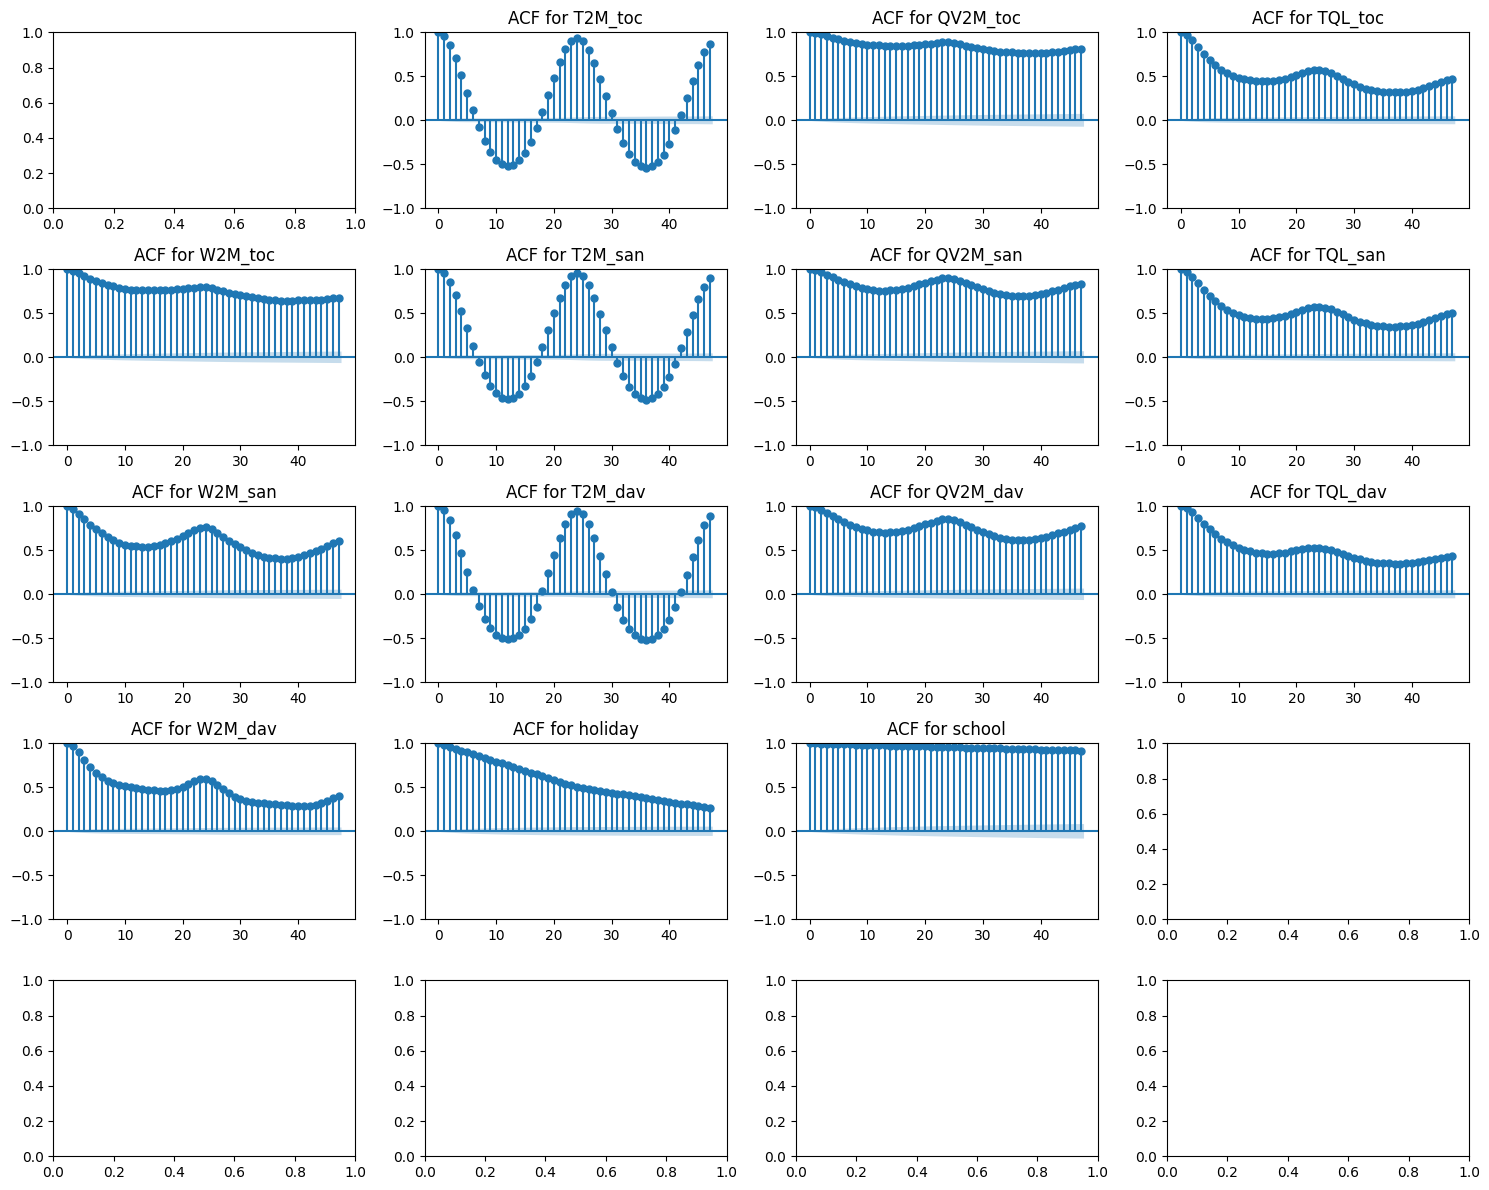

In [14]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Function to plot ACF for multiple features in a grid format
def plot_acf_grid(data, features, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 12))
    axes = axes.flatten()
    for i, feature in enumerate(features):
        # Check if the feature exists in the DataFrame before plotting
        if feature in data.columns:
            plot_acf(data[feature].dropna(), ax=axes[i], title=f'ACF for {feature}')
        else:
            print(f"Warning: Feature '{feature}' not found in the DataFrame.")
    plt.tight_layout()
    plt.show()

# Define features
features = ['Nat_Demand', 'T2M_toc', 'QV2M_toc', 'TQL_toc', 'W2M_toc', 'T2M_san', 'QV2M_san',
            'TQL_san', 'W2M_san', 'T2M_dav', 'QV2M_dav', 'TQL_dav', 'W2M_dav',
            'holiday', 'school', 'Hour', 'Day_of_Week', 'Month', 'Year']

# Plot ACF for features in a grid format
plot_acf_grid(continuous_dataset, features, rows=5, cols=4)

In [20]:
# Plot the Pie chart and bar chart for continuous dataset
# Pie chart of demand by day of the week
demand_by_day = continuous_dataset.groupby('Day_of_Week')['Nat_Demand'].sum()
demand_by_day.plot(kind='pie', autopct='%1.1f%%', startangle=90, title='Demand by Day of the Week')
plt.ylabel('')
plt.show()

KeyError: 'Day_of_Week'

In [ ]:
# Bar chart of average demand by hour
average_demand_by_hour = continuous_dataset.groupby('Hour')['Nat_Demand'].mean()
average_demand_by_hour.plot(kind='bar', title='Average Demand by Hour')
plt.xlabel('Hour')
plt.ylabel('Average Demand')
plt.show()

In [ ]:
# Calculate correlation matrix to see demand - other variables' relationship
correlation_matrix = train_df.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# Display the column names of the training dataframe
print(train_df.columns)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Function to plot scatter plots for multiple variables in a grid format
def plot_scatter_grid(data, variables, target, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(20, 15))
    axes = axes.flatten()
    for i, var in enumerate(variables):
        sns.scatterplot(x=data[var], y=data[target], ax=axes[i])
        axes[i].set_title(f'Scatterplot of {var} vs {target}')
        axes[i].set_xlabel(var)
        axes[i].set_ylabel(target)
    plt.tight_layout()
    plt.show()

# Select variables to plot against demand
variables = train_df.columns.drop('Nat_Demand')

# Plot scatter plots for variables in a grid format
plot_scatter_grid(train_df, variables, 'Nat_Demand', rows=4, cols=4)

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

# Plot autocorrelation of demand
plt.figure(figsize=(10, 6))
plot_acf(train_df['Nat_Demand'], lags=50)
plt.title('Autocorrelation of Demand')
plt.show()

In [ ]:
# Add a column for seasons
train_df['Datetime'] = pd.to_datetime(train_df['Datetime'])
train_df['season'] = train_df['Datetime'].dt.month % 12 // 3 + 1

# Plot energy consumption in different seasons
plt.figure(figsize=(12, 8))
sns.boxplot(x='season', y='Nat_Demand', data=train_df)
plt.title('Energy Consumption in Different Seasons')
plt.xlabel('Season')
plt.ylabel('Demand')
plt.show()

## Modeling

In [ ]:
# Assume 'DEMAND' is the correct column for target
train_df.rename(columns={'datetime': 'Datetime', 'DEMAND': 'Nat_Demand'}, inplace=True)
test_df.rename(columns={'datetime': 'Datetime', 'DEMAND': 'Nat_Demand'}, inplace=True)
continuous_dataset.rename(columns={'datetime': 'Datetime', 'nat_demand': 'Nat_Demand'}, inplace=True)


In [ ]:
# Augmented Dickey-Fuller Test
result = adfuller(train_df['Nat_Demand'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(train_df['Nat_Demand'], model='additive', period=24)
decomposition.plot()
plt.show()

In [ ]:
# Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(train_df['Nat_Demand'], model='additive', period=24)
decomposition.plot()
plt.show()


In [ ]:
# Exponential Smoothing Model
model = ExponentialSmoothing(train_df['Nat_Demand'], seasonal='additive', seasonal_periods=24).fit()
pred = model.forecast(len(test_df))
plt.plot(train_df['Datetime'], train_df['Nat_Demand'], label='Train')
plt.plot(test_df['Datetime'], test_df['Nat_Demand'], label='Test')
plt.plot(test_df['Datetime'], pred, label='Holt-Winters')
plt.legend()
plt.show()


Train Data (Blue Line): This line shows the actual national electricity demand for the training period.

Test Data (Orange Line): This line shows the actual national electricity demand for the test period. This data is used to evaluate the model's forecasting performance.

Holt-Winters Forecast (Green Line): This line represents the predicted national electricity demand for the test period.

In [ ]:
# The SARIMAX model
def evaluate_arima_model(X, arima_order):
    model = SARIMAX(X, order=arima_order)
    model_fit = model.fit(disp=0)
    yhat = model_fit.predict(len(X), len(X))
    return yhat


In [ ]:
# Make a function to evaluate the different ARIMA models with different p, d, and q values
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [ ]:
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)
evaluate_models(train_df['Nat_Demand'], p_values, d_values, q_values)

# Visualize the results
sarimax_model = SARIMAX(train_df['Nat_Demand'], order=(1,1,1))
sarimax_fit = sarimax_model.fit(disp=False)
sarimax_pred = sarimax_fit.predict(start=len(train_df), end=len(train_df)+len(test_df)-1, dynamic=False)
plt.plot(train_df['Datetime'], train_df['Nat_Demand'], label='Train')
plt.plot(test_df['Datetime'], test_df['Nat_Demand'], label='Test')
plt.plot(test_df['Datetime'], sarimax_pred, label='SARIMAX')
plt.legend()
plt.show()

Evaluating different ARIMA models with various parameters and then visualizing the results using the SARIMAX model can be seen above. The plot visually shows how well the SARIMAX model's predictions match the actual observed demand in the test set. Ideally, the green line should closely follow the orange line if the model is accurate.

In [ ]:
# Application: Forecasting
forecast_length = 24*7
forecast = sarimax_fit.predict(start=len(train_df), end=len(train_df)+forecast_length-1, dynamic=False)
forecast_dates = pd.date_range(start=train_df['Datetime'].iloc[-1], periods=forecast_length + 1, freq='H')[1:]

plt.plot(train_df['Datetime'], train_df['Nat_Demand'], label='Historical')
plt.plot(forecast_dates, forecast, label='Forecast')
plt.legend()
plt.show()

(Blue Line): This line represents the historical national electricity demand data used for training the SARIMAX model.

(Orange Line): This line represents the predicted electricity demand for the next week after the end of the training period.